In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
# setting up the constants

BATCH_SIZE = 32 
# BATCH_SIZE = 5
IMAGE_SIZE_H = 405
IMAGE_SIZE_W = 720
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "H-pylori",
    shuffle=True,
    image_size=(IMAGE_SIZE_H, IMAGE_SIZE_W),
    batch_size=BATCH_SIZE
)

Found 4629 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Negative_case', 'Positive_case']

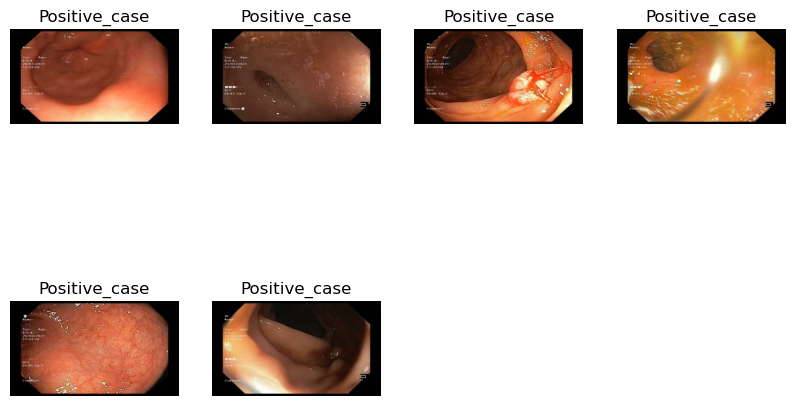

In [5]:
# visualizing some images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

116

In [9]:
len(val_ds)

14

In [10]:
len(test_ds)

15

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Creating a Layer for Resizing and Normalization

#to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
#This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.
#somone can supply an image that is not (256,256) and this layer will resize it

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE_H, IMAGE_SIZE_W),
  tf.keras.layers.Rescaling(1./255),
])

In [13]:
#boost the accuracy of our model by augmenting the data

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [14]:
# Applying data augmentation to train dataset

# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
#the model is CNN coupled with a Softmax activation in the output layer. 
# Added the initial layers for resizing, normalization and Data Augmentation.
input_shape = (BATCH_SIZE, IMAGE_SIZE_H, IMAGE_SIZE_W, CHANNELS)
n_classes = 3

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE_H, IMAGE_SIZE_W, CHANNELS)),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

#model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 405, 720, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 403, 718, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 201, 359, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 199, 357, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 99, 178, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 97, 176, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 48, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 46, 86, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 21, 41, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 18, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,819 (1.20 MB)

 Trainable params: 314,819 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# compiling the model using adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1071s 8s/step - accuracy: 0.8022 - loss: 0.5550 - val_accuracy: 0.8627 - val_loss: 0.3709
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 935s 8s/step - accuracy: 0.8603 - loss: 0.4031 - val_accuracy: 0.8581 - val_loss: 0.4182
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 908s 8s/step - accuracy: 0.8571 - loss: 0.3668 - val_accuracy: 0.9153 - val_loss: 0.2072
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 906s 8s/step - accuracy: 0.8970 - loss: 0.2678 - val_accuracy: 0.9222 - val_loss: 0.1745
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 895s 8s/step - accuracy: 0.9293 - loss: 0.1907 - val_accuracy: 0.9634 - val_loss: 0.1249
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 896s 8s/step - accuracy: 0.9455 - loss: 0.1400 - val_accuracy: 0.9771 - val_loss: 0.0873
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 895s 8s/step - accuracy: 0.9675 - loss: 0.0855 - val_accuracy: 0.9840 - val_loss: 0.0563
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 909s 8s/step - accuracy: 0.9713 - loss: 0.0712 - val_acc

116/116 ━━━━━━━━━━━━━━━━━━━━ 896s 8s/step - accuracy: 1.0000 - loss: 4.7217e-06 - val_accuracy: 0.9908 - val_loss: 0.0522


In [19]:
#### we will now run a test on test dataset this is to check how well your model is performing by trying it out on a test data set
scores = model.evaluate(test_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9997 - loss: 0.0011  


In [20]:
scores

[0.008629629388451576, 0.9979166388511658]

In [21]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 116}

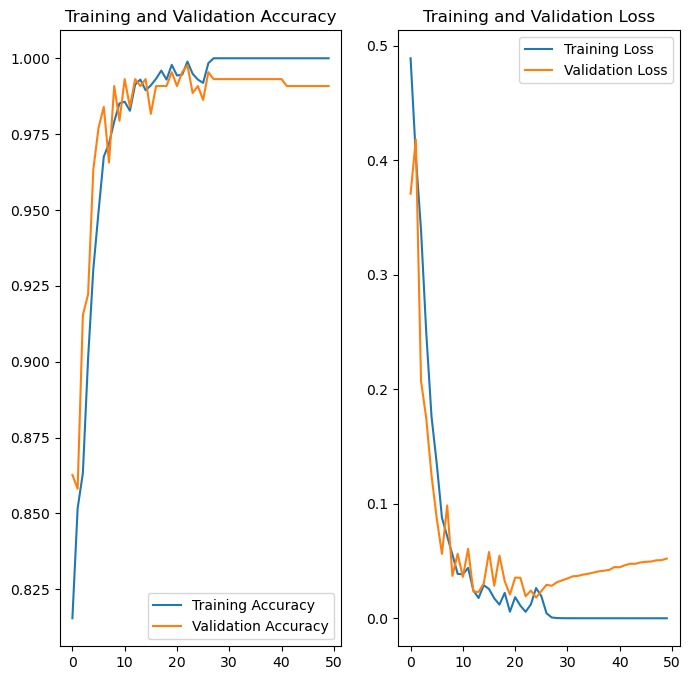

In [22]:
#putting it in variables which will be used for visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Positive_case
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: Positive_case


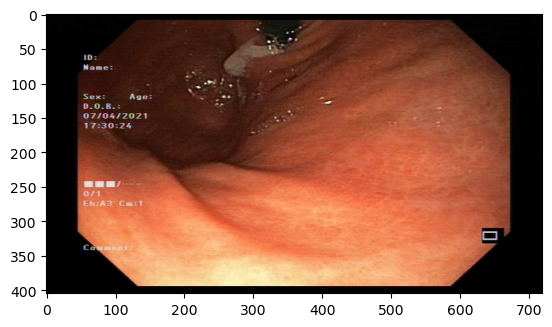

In [23]:
#now running prediction on test/sample image

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: Negative_case
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Negative_case


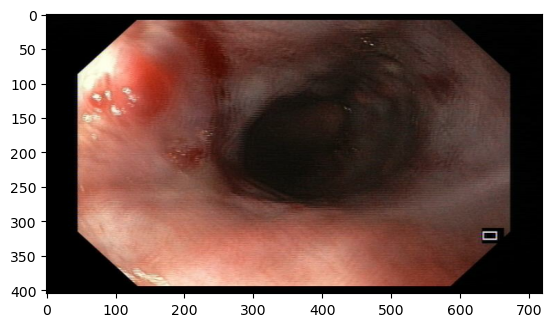

In [24]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
#writing function for inference
#a simple function taking model and img as input and giving predicted class and confidence as an output
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) #converts the image into image array
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


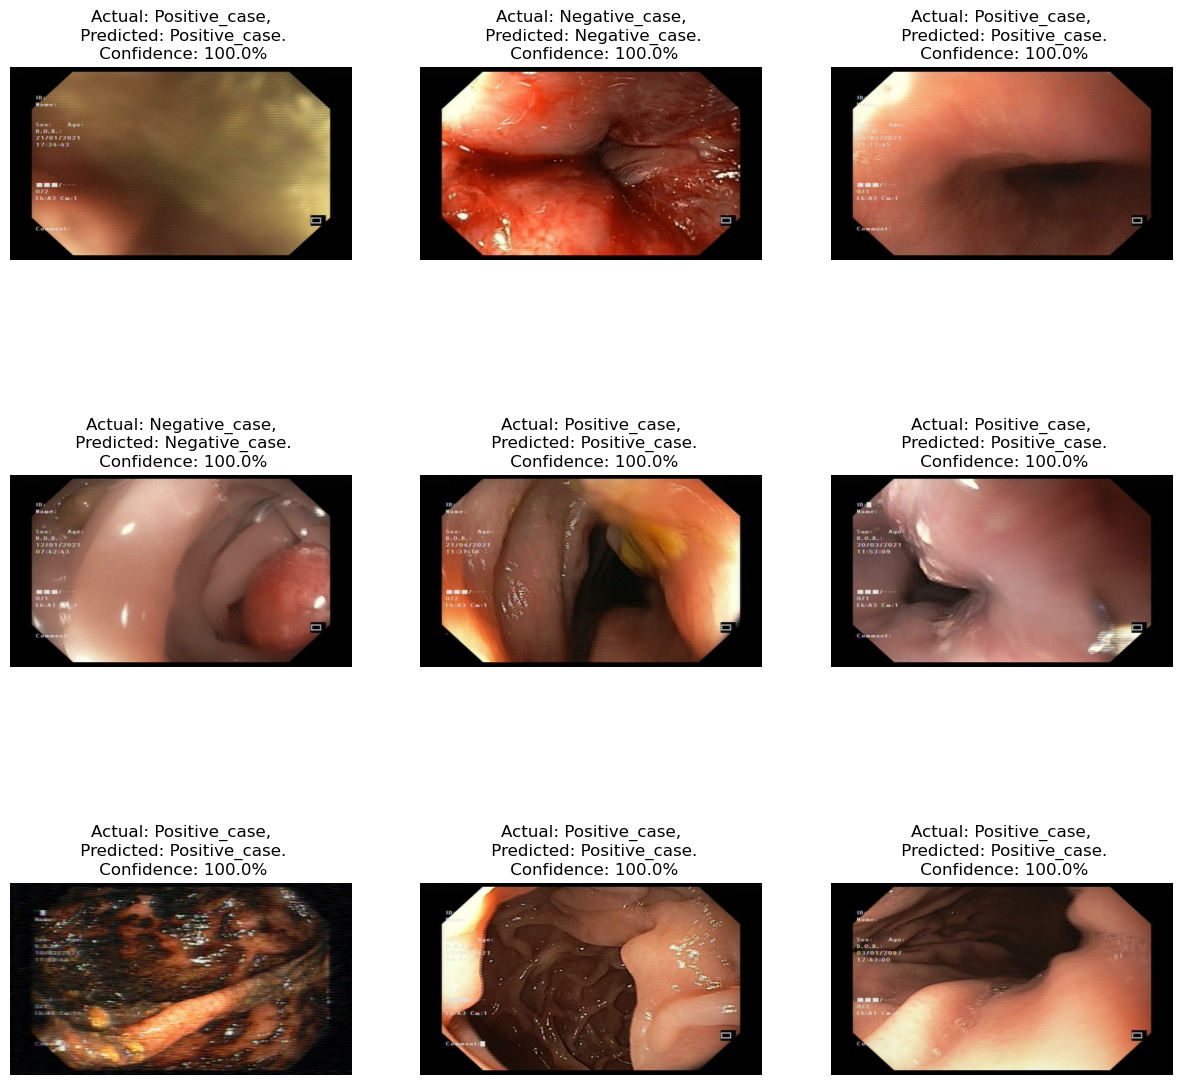

In [26]:
#running inference on few sample images

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
#saving the model, the model will be appended with the list of models. this step is pretty much same in every model building therefore this is not going to change,
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("../hpylori.h5")